In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#%autoreload # When utils.py is updated
#from utils_unet_resunet import *
from ops import create_mask, metrics_AP, complete_nan_values
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from model.callbacks import UpdateWeights
from model.models import UNET
from model.losses import WBCE
import matplotlib.pyplot as plt
import time
import tensorflow as tf
import os
import gc
import json
import importlib
import numpy as np

## Parameters

In [3]:
with open(f'00_params.json') as param_file:
    params = json.load(param_file)

img_path = 'imgs' 
n_opt_layer = 26 #number of OPT layers, used to split de input data between OPT and SAR

number_class = 3
weights = params['weights']
times= params['times']
exp = params['exp']

overlap = params['overlap']
patch_size = params['patch_size']
batch_size = params['batch_size']

img_type = params['img_type']
cond = params['cond']
test_cond = params['test_cond']

nb_filters = params['nb_filters']

method = params['method']
module = importlib.import_module('model.models')
exp_model = getattr(module, method)

grid_size = params['grid_size']

tiles_tr = params['tiles_tr']
tiles_val = params['tiles_val']

## Load file

In [4]:
print(f'Experiment: {exp}')
print(f'Model: {method}')
print(f'Test cond: {test_cond}')

Experiment: 99
Model: Concat_UNET
Test cond: no_cloudy


In [5]:
#final_mask1 = np.load(os.path.join(img_path, 'final_mask1.npy'))
final_mask1 = np.lib.format.open_memmap(os.path.join(img_path, 'final_mask1.npy'))
print('Labels stack:', final_mask1.shape)
#h_, w_, channels = image_array.shape

Labels stack: (17730, 9203)


## Create tiles mask

mask:  (17730, 9203)
ref : (17730, 9203)


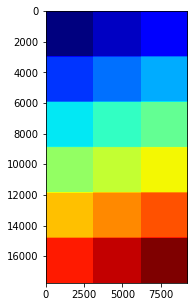

In [6]:
mask_tiles = create_mask(final_mask1.shape[0], final_mask1.shape[1], grid_size=grid_size)
#image_array = image_array[:mask_tiles.shape[0], :mask_tiles.shape[1],:]
#final_mask1 = final_mask1[:mask_tiles.shape[0], :mask_tiles.shape[1]]

print('mask: ',mask_tiles.shape)
#print('image stack: ', image_array.shape)
print('ref :', final_mask1.shape)
plt.figure(figsize=(10,5))
plt.imshow(mask_tiles, cmap='jet')

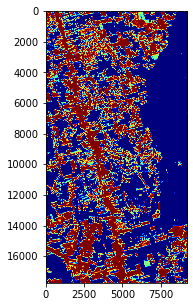

In [7]:
plt.figure(figsize=(10,5))
plt.imshow(final_mask1, cmap = 'jet')

## Define tiles for training, validation and tests.

In [8]:
tiles_ts = (list(set(np.arange(20)+1)-set(tiles_tr)-set(tiles_val)))

mask_amazon_ts = np.zeros_like(mask_tiles, dtype = np.uint8)
for ts_ in tiles_ts:
    mask_amazon_ts[mask_tiles == ts_] = 1

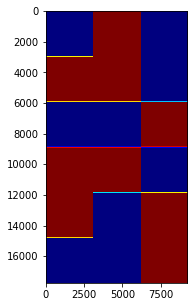

In [9]:
plt.figure(figsize=(10,5))
plt.imshow(mask_amazon_ts, cmap='jet')

In [10]:
path_exp = os.path.join(img_path, 'experiments', f'exp_{exp}')
path_models = os.path.join(path_exp, 'models')
path_maps = os.path.join(path_exp, 'pred_maps')

if not os.path.exists(path_exp):
    os.makedirs(path_exp)   
if not os.path.exists(path_models):
    os.makedirs(path_models)   
if not os.path.exists(path_maps):
    os.makedirs(path_maps)

In [11]:
mean_prob_opt = np.lib.format.open_memmap(os.path.join(path_maps, 'prob_mean_opt.npy'))
mean_prob_sar = np.lib.format.open_memmap(os.path.join(path_maps, 'prob_mean_sar.npy'))
mean_prob_fus = np.lib.format.open_memmap(os.path.join(path_maps, 'prob_mean_fus.npy'))
mean_prob_comb = np.lib.format.open_memmap(os.path.join(path_maps, 'prob_mean_comb.npy'))

(-0.5, 9202.5, 17729.5, -0.5)

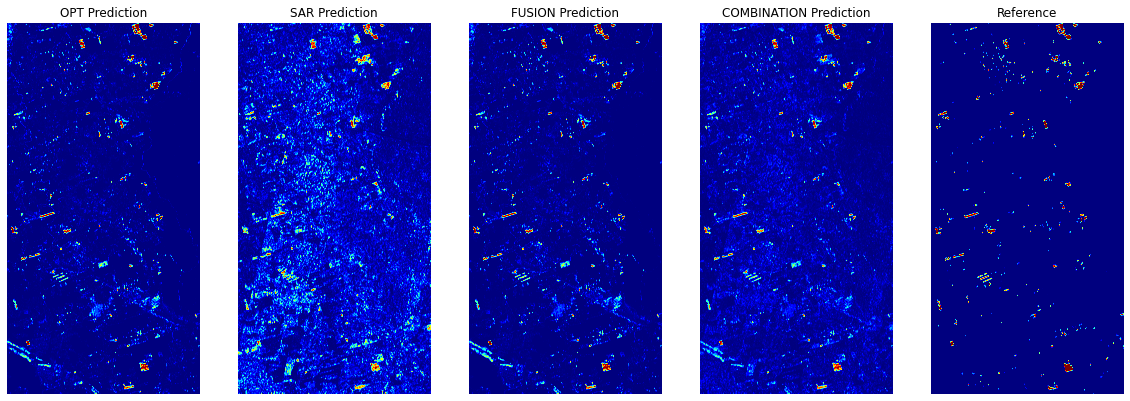

In [12]:
# Plot mean map and reference
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(151)
plt.title('OPT Prediction')
ax1.imshow(mean_prob_opt, cmap ='jet')
ax1.axis('off')

ax1 = fig.add_subplot(152)
plt.title('SAR Prediction')
ax1.imshow(mean_prob_sar, cmap ='jet')
ax1.axis('off')

ax1 = fig.add_subplot(153)
plt.title('FUSION Prediction')
ax1.imshow(mean_prob_fus, cmap ='jet')
ax1.axis('off')

ax1 = fig.add_subplot(154)
plt.title('COMBINATION Prediction')
ax1.imshow(mean_prob_comb, cmap ='jet')
ax1.axis('off')

ax2 = fig.add_subplot(155)
plt.title('Reference')
ax2.imshow(tf.keras.utils.to_categorical(final_mask1, 3)[:,:,1], cmap ='jet')
ax2.axis('off')

In [13]:
# Computing metrics
t0 = time.time()
mean_prob_opt = mean_prob_opt[:final_mask1.shape[0], :final_mask1.shape[1]]
mean_prob_sar = mean_prob_sar[:final_mask1.shape[0], :final_mask1.shape[1]]
mean_prob_fus = mean_prob_fus[:final_mask1.shape[0], :final_mask1.shape[1]]
mean_prob_comb = mean_prob_comb[:final_mask1.shape[0], :final_mask1.shape[1]]

ref1 = np.ones_like(final_mask1).astype(np.float32)

ref1 [final_mask1 == 2] = 0
TileMask = mask_amazon_ts * ref1
GTTruePositives = final_mask1==1
    
Npoints = 50

Pmax_opt = np.max(mean_prob_opt[GTTruePositives * TileMask ==1])
ProbList_opt = np.linspace(Pmax_opt,0,Npoints)

Pmax_sar = np.max(mean_prob_sar[GTTruePositives * TileMask ==1])
ProbList_sar = np.linspace(Pmax_sar,0,Npoints)

Pmax_fus = np.max(mean_prob_fus[GTTruePositives * TileMask ==1])
ProbList_fus = np.linspace(Pmax_fus,0,Npoints)

Pmax_comb = np.max(mean_prob_comb[GTTruePositives * TileMask ==1])
ProbList_comb = np.linspace(Pmax_comb,0,Npoints)

del ref1, TileMask, GTTruePositives
gc.collect()

print('Evaluating OPT metrics...')
metrics_opt = metrics_AP(ProbList_opt, mean_prob_opt, final_mask1, mask_amazon_ts, 625, 5)
print('Evaluating SAR metrics...')
metrics_sar = metrics_AP(ProbList_sar, mean_prob_sar, final_mask1, mask_amazon_ts, 625, 5)
print('Evaluating FUS metrics...')
metrics_fus = metrics_AP(ProbList_fus, mean_prob_fus, final_mask1, mask_amazon_ts, 625, 5)
print('Evaluating COMB metrics...')
metrics_comb = metrics_AP(ProbList_comb, mean_prob_comb, final_mask1, mask_amazon_ts, 625, 5)

    
np.save(os.path.join(path_exp, 'acc_metrics_opt.npy'), metrics_opt)
np.save(os.path.join(path_exp, 'acc_metrics_sar.npy'), metrics_sar)
np.save(os.path.join(path_exp, 'acc_metrics_fus.npy'), metrics_fus)
np.save(os.path.join(path_exp, 'acc_metrics_comb.npy'), metrics_comb)
print(f'elapsed time: {(time.time()-t0)/60} mins')

Evaluating OPT metrics...
Evaluating SAR metrics...
Evaluating FUS metrics...
Evaluating COMB metrics...
elapsed time: 130.46827113231024 mins


In [14]:
# Complete NaN values
metrics_copy_opt = np.array(metrics_opt)
metrics_copy_opt = complete_nan_values(metrics_copy_opt)

metrics_copy_sar = np.array(metrics_sar)
metrics_copy_sar = complete_nan_values(metrics_copy_sar)

metrics_copy_fus = np.array(metrics_fus)
metrics_copy_fus = complete_nan_values(metrics_copy_fus)

metrics_copy_comb = np.array(metrics_comb)
metrics_copy_comb = complete_nan_values(metrics_copy_comb)

OPT mAP 0.8125538572783811
SAR mAP 0.5668809744593251
FUSION mAP 0.823374106283139
COMBINATION mAP 0.8262066259346432


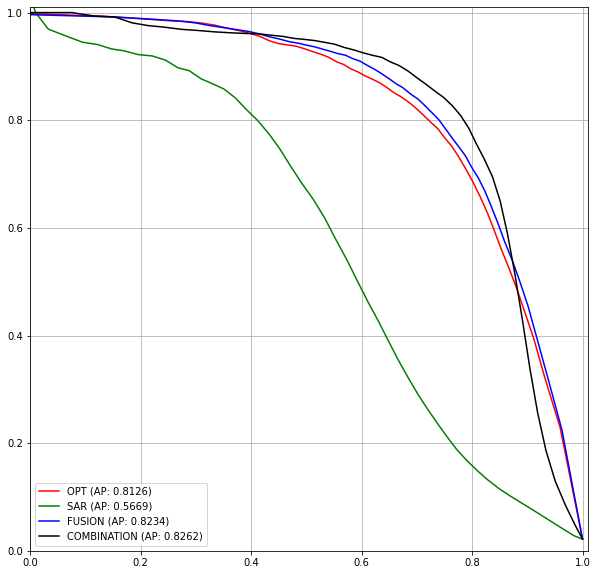

In [15]:
# Comput Mean Average Precision (mAP) score 
Recall_opt = metrics_copy_opt[:,0]
Precision_opt = metrics_copy_opt[:,1]
AA_opt = metrics_copy_opt[:,2]

Recall_sar = metrics_copy_sar[:,0]
Precision_sar = metrics_copy_sar[:,1]
AA_sar = metrics_copy_sar[:,2]

Recall_fus = metrics_copy_fus[:,0]
Precision_fus = metrics_copy_fus[:,1]
AA_fus = metrics_copy_fus[:,2]

Recall_comb = metrics_copy_comb[:,0]
Precision_comb = metrics_copy_comb[:,1]
AA_comb = metrics_copy_comb[:,2]
    
Recall_opt_ = np.insert(Recall_opt, 0, 0)
Precision_opt_ = np.insert(Precision_opt, 0, Precision_opt[0])
DeltaR_opt = Recall_opt_[1:]-Recall_opt_[:-1]
AP_opt = np.sum(Precision_opt_[1:]*DeltaR_opt)
print('OPT mAP', AP_opt)

Recall_sar_ = np.insert(Recall_sar, 0, 0)
Precision_sar_ = np.insert(Precision_sar, 0, Precision_sar[0])
DeltaR_sar = Recall_sar_[1:]-Recall_sar_[:-1]
AP_sar = np.sum(Precision_sar_[1:]*DeltaR_sar)
print('SAR mAP', AP_sar)

Recall_fus_ = np.insert(Recall_fus, 0, 0)
Precision_fus_ = np.insert(Precision_fus, 0, Precision_fus[0])
DeltaR_fus = Recall_fus_[1:]-Recall_fus_[:-1]
AP_fus = np.sum(Precision_fus_[1:]*DeltaR_fus)
print('FUSION mAP', AP_fus)

Recall_comb_ = np.insert(Recall_comb, 0, 0)
Precision_comb_ = np.insert(Precision_comb, 0, Precision_comb[0])
DeltaR_comb = Recall_comb_[1:]-Recall_comb_[:-1]
AP_comb = np.sum(Precision_comb_[1:]*DeltaR_comb)
print('COMBINATION mAP', AP_comb)

# Plot Recall vs. Precision curve
plt.figure(figsize=(10,10))
plt.plot(metrics_copy_opt[:,0],metrics_copy_opt[:,1], 'r-', label = f'OPT (AP: {AP_opt:.4f})')
plt.plot(metrics_copy_sar[:,0],metrics_copy_sar[:,1], 'g-', label = f'SAR (AP: {AP_sar:.4f})')
plt.plot(metrics_copy_fus[:,0],metrics_copy_fus[:,1], 'b-', label = f'FUSION (AP: {AP_fus:.4f})')
plt.plot(metrics_copy_comb[:,0],metrics_copy_comb[:,1], 'k-', label = f'COMBINATION (AP: {AP_comb:.4f})')
plt.legend(loc="lower left")
ax = plt.gca()
ax.set_ylim([0,1.01])
ax.set_xlim([0,1.01])
#plt.plot(metrics_copy[:,0],metrics_copy[:,2])
plt.grid()
plt.savefig(os.path.join(path_exp, 'result.png'))